In [2]:
import pandas as pd
import numpy as np
import yfinance as yf 
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib 
import pandas_datareader.data as web

In [3]:
btc_data = yf.download('BTC-USD', start='2017-01-01', end='2022-01-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
btc_df = pd.DataFrame(btc_data)

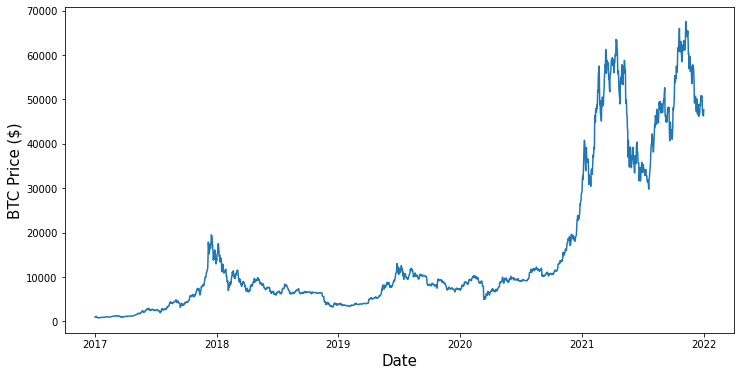

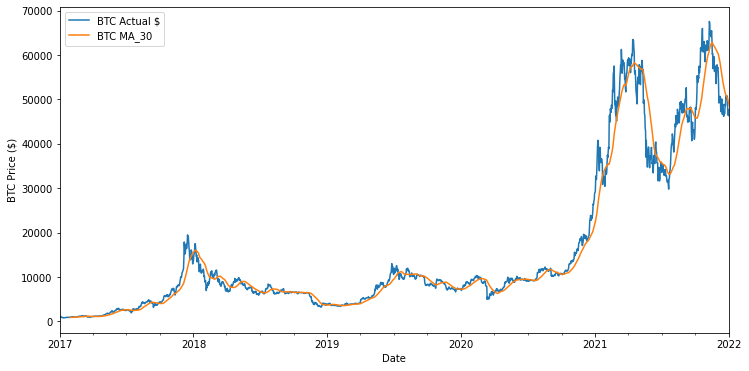

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(btc_df["Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('BTC Price ($)',fontsize=15)
plt.show()

close_px = btc_df['Close']
mavg = close_px.rolling(window=30).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='BTC Actual $')
mavg.plot(label='BTC MA_30')
plt.xlabel('Date')
plt.ylabel('BTC Price ($)')
plt.legend()

In [6]:
import matplotlib.dates as mdates

dates_df = btc_df.copy()
dates_df = dates_df.reset_index()

org_dates = dates_df['Date']

dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1822,738152.0,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883
1823,738153.0,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299
1824,738154.0,46490.605469,47879.964844,46060.312500,47178.125000,47178.125000,26686491018
1825,738155.0,47169.371094,48472.527344,45819.953125,46306.445312,46306.445312,36974172400
1826,738156.0,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
prices = np.array(btc_df['Close'])
prices = np.reshape(prices, (-1, 1))

scaler.fit(prices)
prices = scaler.transform(prices)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


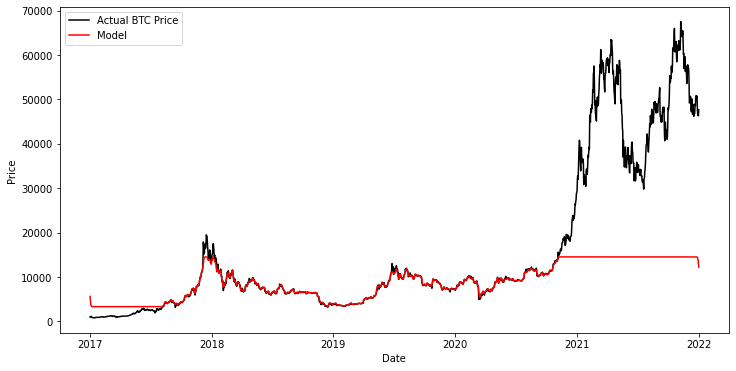

In [8]:
from sklearn.svm import SVR
from sklearn import svm

svr_model = svm.SVR()

dates = np.array(dates_df['Date'])
prices = np.array(btc_df['Close'])

dates = np.reshape(dates, (-1, 1)) 
prices = np.reshape(prices, (-1, 1))

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, prices) 

plt.figure(figsize = (12,6))
plt.plot(dates, prices, color= 'black', label= 'Actual BTC Price')
plt.plot(org_dates, svr_rbf.predict(dates), color= 'red', label= 'Model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
train_data = prices
print(train_data.shape)  

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(1827, 1)


In [10]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)
 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1791, 36, 1)
X_train:
[[ 998.32501221]
 [1021.75      ]
 [1043.83996582]
 [1154.72998047]
 [1013.38000488]
 [ 902.20098877]
 [ 908.58502197]
 [ 911.19897461]
 [ 902.82800293]
 [ 907.67901611]
 [ 777.75701904]
 [ 804.83398438]
 [ 823.98400879]
 [ 818.4119873 ]
 [ 821.79797363]
 [ 831.53399658]
 [ 907.93798828]
 [ 886.61798096]
 [ 899.07299805]
 [ 895.02600098]
 [ 921.78900146]
 [ 924.67297363]
 [ 921.01202393]
 [ 892.68701172]
 [ 901.54199219]
 [ 917.58599854]
 [ 919.75      ]
 [ 921.59002686]
 [ 919.49597168]
 [ 920.38201904]
 [ 970.40301514]
 [ 989.02301025]
 [1011.79998779]
 [1029.91003418]
 [1042.90002441]
 [1027.33996582]]


y_train: [[1038.15002441]]



In [11]:
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
126/126 [==============================] - 10s 49ms/step - loss: 4.9527e-04 - val_loss: 0.0139
Epoch 2/20
126/126 [==============================] - 5s 43ms/step - loss: 2.1975e-04 - val_loss: 0.0038
Epoch 3/20
126/126 [==============================] - 5s 43ms/step - loss: 1.7299e-04 - val_loss: 0.0075
Epoch 4/20
126/126 [==============================] - 5s 42ms/step - loss: 1.8675e-04 - val_loss: 0.0069
Epoch 5/20
126/126 [==============================] - 5s 42ms/step - loss: 1.5446e-04 - val_loss: 0.0060
Epoch 6/20
126/126 [==============================] - 5s 42ms/step - loss: 1.4057e-04 - val_loss: 0.0030
Epoch 7/20
126/126 [==============================] - 5s 43ms/step - loss: 1.4245e-04 - val_loss: 0.0072
Epoch 8/20
126/126 [==============================] - 5s 43ms/step - loss: 1.1730e-04 - val_loss: 0.0104
Epoch 9/20
126/126 [==============================] - 7s 58ms/step - loss: 1.2934e-04 - val_loss: 0.0032
Epoch 10/20
126/126 [==============================] -

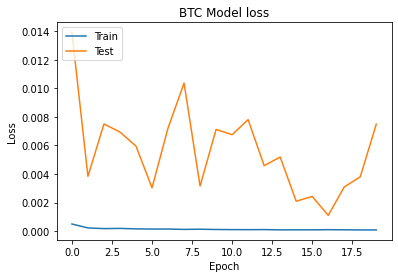

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BTC Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
model.evaluate(X_train, y_train)

56/56 [==============================] - 1s 18ms/step - loss: 0.0023


0.002319521037861705

In [13]:
predicted = model.predict(X_train)

In [14]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_train.reshape(-1,1))

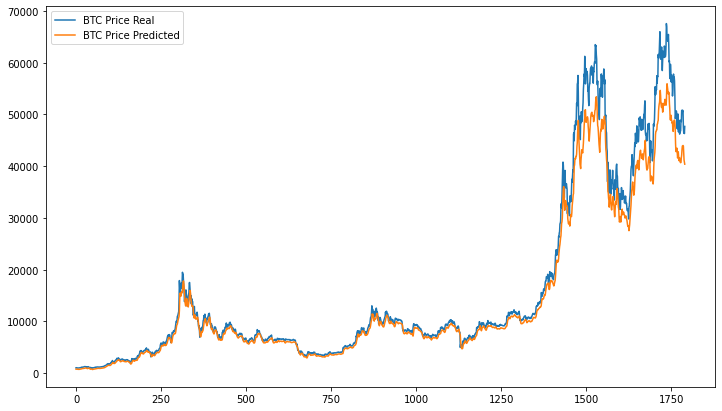

In [15]:
stocks = pd.DataFrame({
    'BTC Price Real': real_prices.ravel(),
    'BTC Price Predicted': predicted_prices.ravel()},
)
stocks.head()


stocks.plot(figsize=(12,7))